<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/notebooks/3_Feat_Importance_RegVsTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part - 3: Visualize the feature importance and feature selection process
- Regression based approach, such as Ridge regression, LASSO, Elastic Net or LARS

    `vs`

- Decision tree based approach (random forest, XGBoost)

Importing libraries.

In [4]:
%%bash

pip install pandas yfinance ta seaborn matplotlib pandas-datareader jinja2 fredapi openpyxl xgboost scikit-learn statsmodels mlflow


In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import xgboost as xgb
from xgboost import XGBRegressor
import mlflow
import math

plt.rcParams["figure.figsize"] = (15, 20)

In [6]:
# Check if the mlflow is running | using the command "docker ps"
# mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.set_experiment("info7374_nvdia_model")

Define start and end dates. Frequency is daily.

In [7]:
# Define dataset start and end date => Two years worth of data
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)


# Downloaded data
NVDA_STOCK = yf.download("NVDA", start_date, end_date)

NVDA_STOCK.describe()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,994.000000,994.000000,994.000000,994.000000,994.000000,9.940000e+02
mean,207.477927,211.407613,203.429328,207.608999,207.387714,4.655021e+07
std,114.276104,115.977335,112.252192,114.138493,114.188053,1.902834e+07
min,50.025002,52.485001,45.169998,49.099998,48.938133,9.788400e+06
25%,131.061245,133.719372,129.195621,131.403122,131.168472,3.328000e+07
50%,173.395004,177.705002,168.970001,173.676254,173.492271,4.386085e+07
75%,261.560005,266.315002,256.330002,263.610008,263.295097,5.680942e+07
max,502.160004,505.480011,492.220001,504.089996,504.045685,1.543911e+08


Calculating daily returns:

In [8]:
nvda = pd.read_csv("https://raw.githubusercontent.com/piyush-an/INFO7374_Predict_StockPrice/main/notebooks/NVDA_feature_mart.csv?token=GHSAT0AAAAAACHOR727443R4RAIXUSGYE3SZLY5GSA")
nvda.set_index("Unnamed: 0", inplace=True)
nvda = nvda.drop(["Adj Close"], axis=1)
nvda

,Open,High,Low,Close,Volume,Returns,Daily_Return,Typical_Price,Typical_Price_Return,Volume_Log,...,Volatility_KeltnerChannel,Mkt-RF,SMB,HML,RF,SP500,DEXJPUS,DEXUSEU,CBBTCUSD,ADS_Index
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2021-10-20,223.050003,224.330002,219.820007,221.029999,14627600.0,-1.867172,-0.008425,221.726669,-0.282228,16.498421,...,217.316335,0.34,-0.02,1.19,0.000,4536.19,114.24,1.1643,66005.17,1.019300
2021-10-21,220.970001,227.110001,220.830002,226.919998,18759000.0,5.881165,0.026299,224.953334,1.444757,16.747184,...,217.404334,0.37,0.21,-0.95,0.000,4549.78,113.75,1.1643,62152.09,1.032460
2021-10-22,228.229996,231.300003,225.610001,227.259995,24938400.0,0.339447,0.001497,228.056666,1.370116,17.031919,...,217.932500,-0.25,-0.24,1.01,0.000,4544.90,113.54,1.1632,60671.75,1.043380
2021-10-25,229.729996,233.550003,227.699997,231.660004,23023500.0,4.393417,0.019176,230.970001,1.269370,16.952026,...,218.739167,0.58,0.49,-0.15,0.000,4566.48,113.70,1.1609,63102.83,1.063390
2021-10-26,239.889999,252.589996,239.240005,247.169998,48589800.0,15.486755,0.064806,246.333333,6.439780,17.698924,...,220.877833,0.04,-0.70,-0.31,0.000,4574.79,114.19,1.1590,60341.21,1.066640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,433.980011,436.500000,415.549988,417.790009,39837900.0,-18.838348,-0.044107,423.279999,-2.386560,17.500329,...,455.716169,-1.58,-0.30,0.84,0.021,4186.77,149.94,1.0583,34489.91,-0.529790
2023-10-26,418.529999,422.559998,398.799988,403.260010,54100100.0,-14.528717,-0.035397,408.206665,-3.626032,17.806347,...,455.207336,-1.15,0.85,1.66,0.021,4137.23,150.44,1.0532,34140.00,-0.521524
2023-10-27,411.299988,412.059998,400.149994,405.000000,41678400.0,1.739838,0.004306,405.736664,-0.606924,17.545494,...,453.846170,-0.53,-0.35,-0.57,0.021,4117.37,149.60,1.0592,33905.16,-0.511475


Separating X and y.

In [9]:
X = nvda.loc[:, nvda.columns != "Close"][:-1]
X = X.drop(["Open", "High", "Low", "Typical_Price"], axis=1)
y = nvda["Close"].shift(-1)[:-1]

In [10]:
y

Unnamed: 0
2021-10-20    226.919998
2021-10-21    227.259995
2021-10-22    231.660004
2021-10-25    247.169998
2021-10-26    244.509995
                 ...    
2023-10-24    417.790009
2023-10-25    403.260010
2023-10-26    405.000000
2023-10-27    411.609985
2023-10-30    407.799988
Name: Close, Length: 505, dtype: float64

## 1. Random Forest Regressors

### Fitting the model and RMSE Calculation

In [11]:
parameter_combinations = [
    # {'n_estimators': 100, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1},
    {"n_estimators": 200, "max_depth": 10, "max_features": None, "min_samples_leaf": 1},
    # {'n_estimators': 150, 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1}
    # Add more parameter combinations as needed
]

# Iterate through each parameter combination
for idx, params in enumerate(parameter_combinations):
    # Start a new run for each parameter combination
    # with mlflow.start_run():  # Assign a unique run name
        # Initialize the RandomForestRegressor with parameters
      # mlflow.sklearn.autolog()
    rf_model = RandomForestRegressor(
        bootstrap=True,
        criterion="squared_error",
        max_depth=params["max_depth"],
        max_features=params["max_features"],
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=params["min_samples_leaf"],
        min_samples_split=2,
        min_weight_fraction_leaf=0.0,
        n_estimators=params["n_estimators"],
        n_jobs=None,
        oob_score=False,
        random_state=None,
        verbose=0,
        warm_start=False,
    )

    # Assuming you have X and y defined for training

    # Fit the model
    rf_model.fit(X, y)
    predictions = rf_model.predict(X)
    MSE = mean_squared_error(y, predictions)
    RMSE = math.sqrt(MSE)

    # Log parameters and metrics for each run
    # mlflow.log_params(params)  # Log model parameters for the run
    # mlflow.log_metric("RMSE", RMSE)  # Log RMSE metric for the run

    # # Add tags or metadata for each run if needed
    # # mlflow.set_tag("algorithm", "RandomForest")
    # mlflow.set_tag("start_date", start_date)
    # mlflow.set_tag("end_date", end_date)

    print(f"Run {idx+1} - Root Mean Square Error: {RMSE}")

Run 1 - Root Mean Square Error: 3.8104249473616854


#### Creating a new dataframe to better understand the Buy-Sell trading signal

In [12]:
results = pd.DataFrame(
    {
        "Actual": list(y),
        "Predicted": list(predictions),
        "Date": nvda.index[:-1],
        "Open": nvda["Open"][:-1],
        "Close": nvda["Close"][:-1],
    }
)
results.set_index("Date", inplace=True)
results = results.loc["2023-06-01":"2023-10-31"]
results.head(10)

,Actual,Predicted,Open,Close
Date,,,,
2023-06-01,393.269989,392.218243,384.890015,397.700012
2023-06-02,391.709991,389.077345,400.970001,393.269989
2023-06-05,386.540009,388.726555,389.089996,391.709991
2023-06-06,374.750000,380.761001,388.299988,386.540009
2023-06-07,385.100006,387.445405,389.149994,374.750000
2023-06-08,387.700012,391.504376,377.239990,385.100006
2023-06-09,394.820007,397.554027,390.369995,387.700012
2023-06-12,410.220001,406.639079,392.000000,394.820007
2023-06-13,429.970001,425.523940,401.859985,410.220001


## Trading Signals for Random Forest Model

In [13]:
amount = 10000  # Initial Amount
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results) - 1):
    if results["Predicted"].iloc[i] > results["Actual"].iloc[i - 1]:
        action.append("Buy at Open & Sell at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Buy at Open", round(portfolio, 2), stocks, round(balance, 2))

        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Sell at Close", round(amount, 2), balance)
        Amount.append(amount)
        Portfolio.append(round(portfolio, 5))

    else:
        action.append("Sell at Open & Buy at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Sell at Open", round(portfolio, 2), "-", stocks, round(balance, 2))

        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Buy Back at Close", round(amount, 2), balance)
        Amount.append(amount)
        Portfolio.append(round(portfolio, 5))
    print("\n")

0 Sell at Open 9622.25 - 25 57
0 Buy Back at Close 9999.5 0


1 Sell at Open 9623.28 - 24 167
1 Buy Back at Close 9605.48 0


2 Sell at Open 9338.16 - 24 204
2 Buy Back at Close 9605.04 0


3 Sell at Open 9319.2 - 24 328
3 Buy Back at Close 9604.96 0


4 Buy at Open 9339.6 24 236
4 Sell at Close 9230.0 0


5 Buy at Open 9053.76 24 372
5 Sell at Close 9614.4 0


6 Buy at Open 9368.88 24 309
6 Sell at Close 9613.8 0


7 Buy at Open 9408.0 24 138
7 Sell at Close 9613.68 0


8 Buy at Open 9242.78 23 178
8 Sell at Close 9613.06 0


9 Sell at Open 9389.52 - 23 153
9 Buy Back at Close 10042.31 0


10 Buy at Open 9798.46 23 232
10 Sell at Close 10042.19 0


11 Buy at Open 9993.5 23 223
11 Sell at Close 10042.16 0


12 Sell at Open 9889.54 - 23 404
12 Buy Back at Close 10479.84 0


13 Sell at Open 10440.24 - 24 149
13 Buy Back at Close 10479.8 0


14 Sell at Open 10140.72 - 24 153
14 Buy Back at Close 10479.0 0


15 Sell at Open 10191.36 - 24 348
15 Buy Back at Close 10478.16 0


16 Buy at Open

### Visualizing the above strategy

Initial_Investment : 10000$
Net Position: 7456.0 $


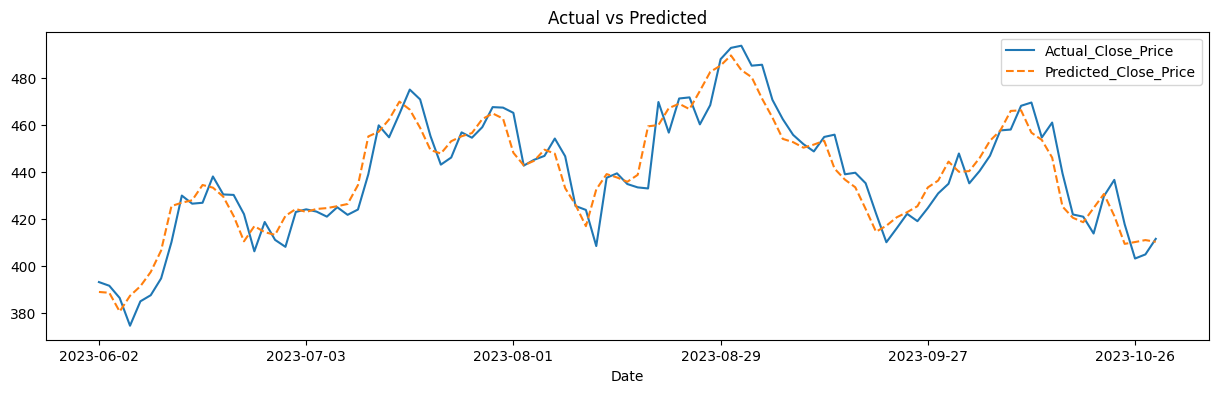

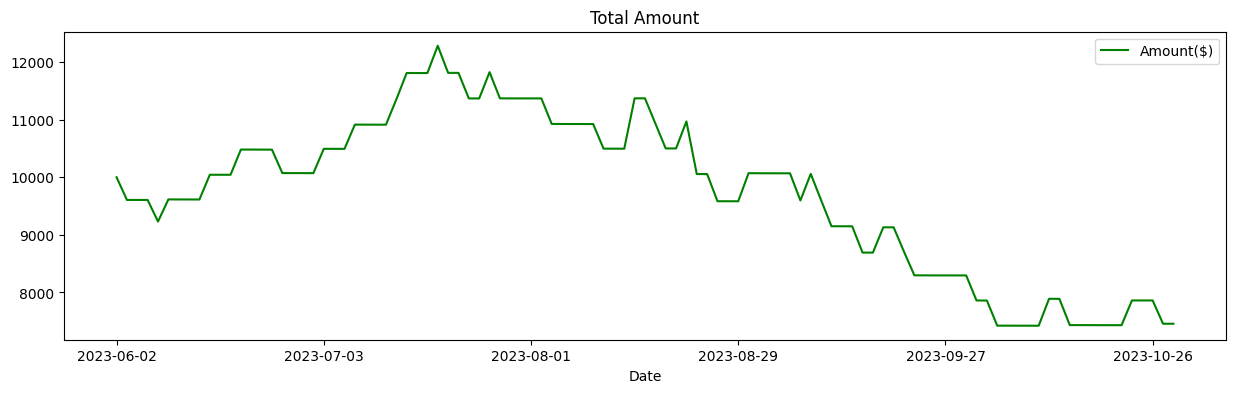

In [14]:
Strategy_Result = pd.DataFrame(
    {
        "Actual_Close_Price": results.Close[1:],
        "Predicted_Close_Price": results.Predicted[1:],
        "Date": results.index[1:],
        "Amount($)": Amount,
    }
)

Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]].plot(
    figsize=(15, 4), style=["-", "--"], title="Actual vs Predicted"
)


Strategy_Result[["Amount($)"]].plot(figsize=(15, 4), style=["-g"], title="Total Amount")

Profit = (Amount[-1]) / 10000
print("Initial_Investment : 10000$")
print("Net Position:", Amount[-1], "$")

In [15]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results) - 1):
    if results["Predicted"].iloc[i + 1] > results["Actual"].iloc[i]:
        if signal == 0:
            action.append("Buy")
            stocks = int(amount / results["Actual"].iloc[i])
            balance = int(amount % results["Actual"].iloc[i])
            portfolio = stocks * results["Actual"].iloc[i]
            signal = 1
            amount = portfolio + balance
            print(
                "Stock:",
                results["Actual"].iloc[i],
                "Action:",
                action[i],
                "Portfolio:",
                round(portfolio, 2),
                "Stocks:",
                stocks,
                "Balance_init:",
                balance,
                "total($)",
                round(amount, 2),
            )
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)
        else:
            action.append("Bought--Holding")
            portfolio = stocks * results["Actual"].iloc[i]
            amount = portfolio + balance
            print(
                "Stock:",
                results["Actual"].iloc[i],
                "Action:",
                action[i],
                "Portfolio:",
                round(portfolio, 2),
                "Stocks:",
                stocks,
                "Balance_init:",
                balance,
                "total($)",
                round(amount, 2),
            )
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)

    elif results["Predicted"].iloc[i + 1] < results["Actual"].iloc[i]:
        if signal == 1:
            action.append("Sell")
            portfolio = stocks * results["Actual"].iloc[i]

            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print(
                "Stock:",
                results["Actual"].iloc[i],
                "Action:",
                action[i],
                "Portfolio:",
                round(portfolio, 2),
                "Stocks:",
                stocks,
                "Balance_init:",
                balance,
                "total($)",
                round(amount, 2),
            )
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)
        else:
            action.append("Price-Prediction-Already-Lower")
            print(
                "Stock:",
                results["Actual"].iloc[i],
                "Action:",
                action[i],
                "Portfolio:",
                round(portfolio, 2),
                "Stocks:",
                stocks,
                "Balance_init:",
                balance,
                "total($)",
                round(amount, 2),
            )
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)

    print("\n")

Stock: 393.2699890136719 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 391.7099914550781 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 386.5400085449219 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 374.75 Action: Buy Portfolio: 9743.5 Stocks: 26 Balance_init: 256 total($) 9999.5


Stock: 385.1000061035156 Action: Bought--Holding Portfolio: 10012.6 Stocks: 26 Balance_init: 256 total($) 10268.6


Stock: 387.7000122070313 Action: Bought--Holding Portfolio: 10080.2 Stocks: 26 Balance_init: 256 total($) 10336.2


Stock: 394.8200073242188 Action: Bought--Holding Portfolio: 10265.32 Stocks: 26 Balance_init: 256 total($) 10521.32


Stock: 410.2200012207031 Action: Bought--Holding Portfolio: 10665.72 Stocks: 26 Balance_init: 256 total($) 10921.72


Stock: 429.9700012207031 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 tota

Initial_Investment : 10000$
Net Position: 24584.0 $


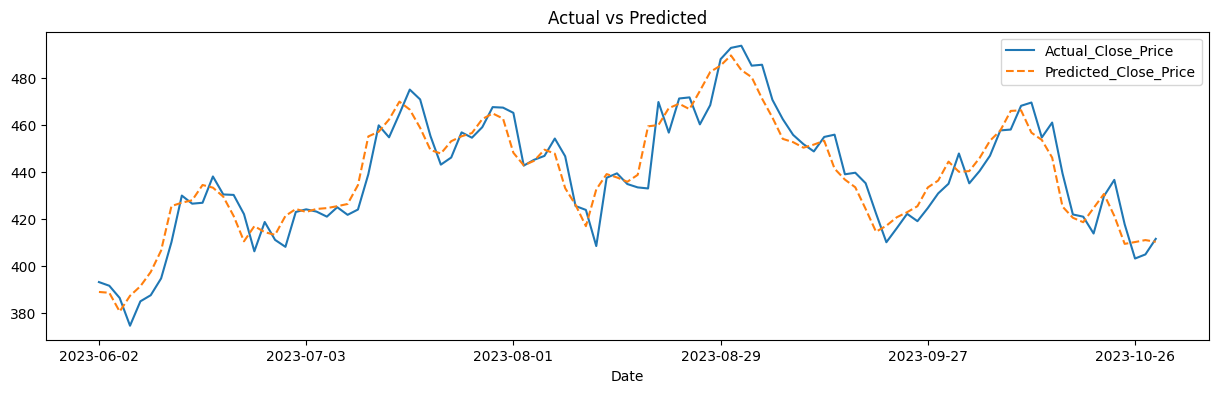

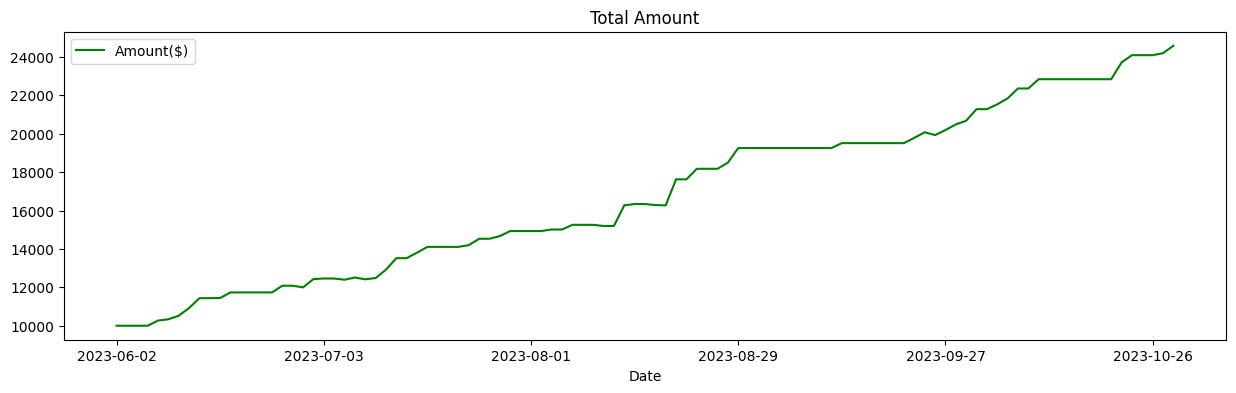

In [16]:
Strategy_Result = pd.DataFrame(
    {
        "Actual_Close_Price": results.Close[1:],
        "Predicted_Close_Price": results.Predicted[1:],
        "Date": results.index[1:],
        "Amount($)": Amount,
    }
)

Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]].plot(
    figsize=(15, 4), style=["-", "--"], title="Actual vs Predicted"
)


Strategy_Result[["Amount($)"]].plot(figsize=(15, 4), style=["-g"], title="Total Amount")

Profit = (Amount[-1]) / 10000
print("Initial_Investment : 10000$")
print("Net Position:", Amount[-1], "$")

In [17]:
Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Amount($)
Date,,,,
2023-06-02,393.269989,389.077345,2023-06-02,10000.0
2023-06-05,391.709991,388.726555,2023-06-05,10000.0
2023-06-06,386.540009,380.761001,2023-06-06,10000.0
2023-06-07,374.750000,387.445405,2023-06-07,10000.0
2023-06-08,385.100006,391.504376,2023-06-08,10269.0


In [18]:
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# # Assuming Strategy_Result is your DataFrame and it contains the 'Amount($)' column

# fig, ax = plt.subplots(figsize=(15, 4))

# def update(frame):
#     ax.clear()
#     ax.plot(Strategy_Result.index[:frame], Strategy_Result['Amount($)'][:frame], '-g')
#     ax.set_title('Total Amount')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Amount($)')

# # Assuming 'num_frames' is the number of frames for the animation
# num_frames = len(Strategy_Result)
# ani = FuncAnimation(fig, update, frames=num_frames, blit=False, repeat=False)

# ani.save('total_amount.gif', writer='pillow', fps=10)  # Save the animation as a GIF
# plt.show()

In [19]:
Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]]

,Actual_Close_Price,Predicted_Close_Price
Date,,
2023-06-02,393.269989,389.077345
2023-06-05,391.709991,388.726555
2023-06-06,386.540009,380.761001
2023-06-07,374.750000,387.445405
2023-06-08,385.100006,391.504376
...,...,...
2023-10-24,436.630005,421.335559
2023-10-25,417.790009,409.479618
2023-10-26,403.260010,410.252966


### Plotting the Actual Price vs. Predicted Price

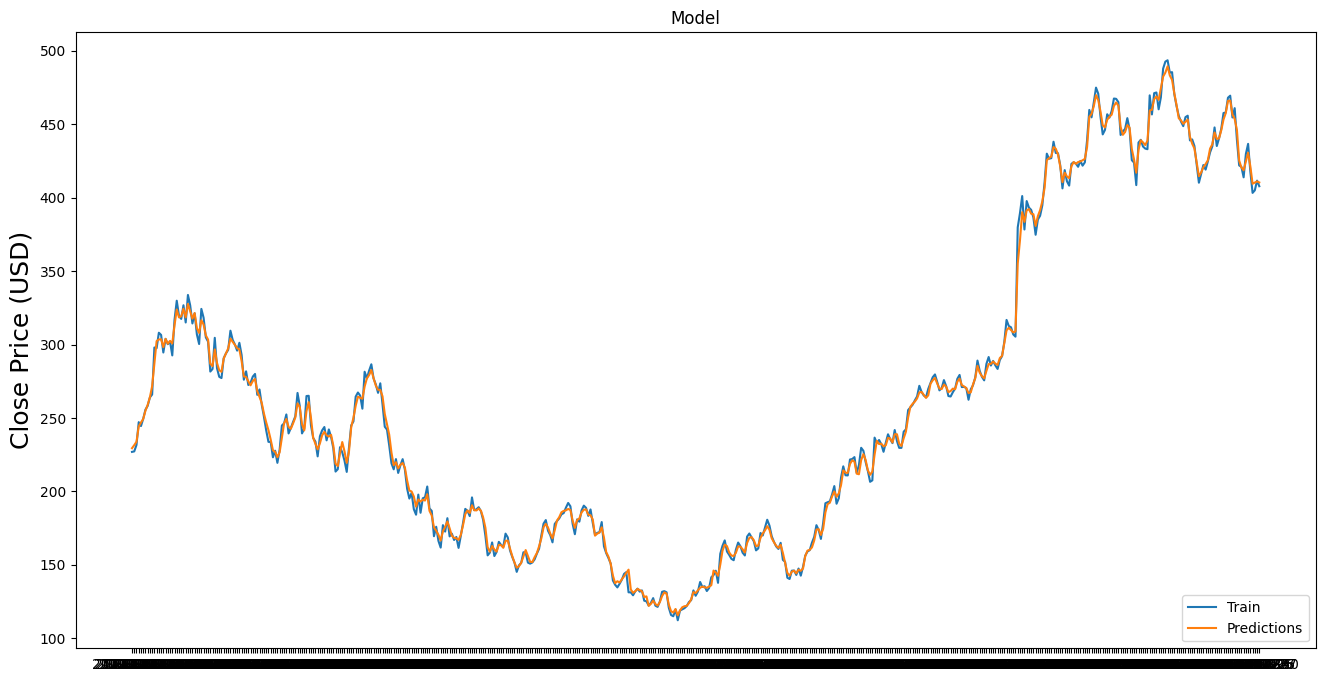

In [20]:
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.ylabel("Close Price (USD)", fontsize=18)
plt.plot(y)
plt.plot(predictions)
plt.legend(["Train", "Predictions"], loc="lower right")
plt.show()

## Feature Importance for Random Forest Model

In [21]:
# Average feature importance
rf_feature_importance = pd.DataFrame(
    rf_model.feature_importances_, index=X.columns, columns=["feature importance"]
).sort_values("feature importance", ascending=False)

#### Plotting top 10 feature importance

<Axes: title={'center': 'Comparison for Feature Importance'}>

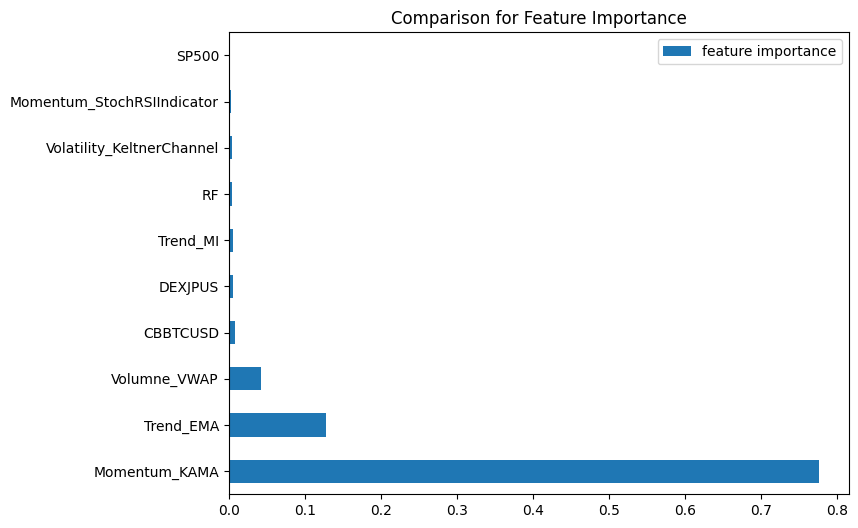

In [22]:
rf_feature_importance[:10].plot(
    kind="barh", title="Comparison for Feature Importance", figsize=(8, 6)
)

In [23]:
# All feature importance for each tree
rf_feature_all = pd.DataFrame(
    [tree.feature_importances_ for tree in rf_model.estimators_], columns=X.columns
)
rf_feature_all.head()

,Volume,Returns,Daily_Return,Typical_Price_Return,Volume_Log,Volume_Differencing,Volume_Differencing_10,Volumne_Percent_Change,MA_5,Volumne_MA_200,...,Volatility_KeltnerChannel,Mkt-RF,SMB,HML,RF,SP500,DEXJPUS,DEXUSEU,CBBTCUSD,ADS_Index
0,0.000056,0.000089,0.000244,0.000352,0.000023,0.000042,0.000242,0.000001,0.000090,5.043766e-05,...,1.029502e-03,0.000057,0.000289,0.000116,3.532957e-03,0.000001,0.004402,0.001036,0.078159,0.000218
1,0.000066,0.000006,0.000067,0.000008,0.000103,0.000008,0.000118,0.000161,0.000011,2.222572e-04,...,1.980229e-04,0.000166,0.000096,0.000802,0.000000e+00,0.000273,0.002793,0.004222,0.009606,0.009475
2,0.000162,0.000010,0.000013,0.000031,0.000056,0.000040,0.000005,0.000013,0.000260,5.373802e-05,...,7.752738e-05,0.000093,0.000014,0.000215,9.355762e-08,0.000314,0.005009,0.003437,0.010448,0.001530
3,0.000134,0.000017,0.000045,0.000000,0.000065,0.000055,0.000148,0.000081,0.000034,3.031659e-07,...,0.000000e+00,0.000116,0.000129,0.000304,1.035602e-06,0.000743,0.012670,0.001871,0.001625,0.000072
4,0.000009,0.000113,0.000033,0.000021,0.000036,0.000062,0.000105,0.000024,0.000177,1.273846e-04,...,7.779502e-08,0.000136,0.000387,0.000058,0.000000e+00,0.000629,0.004244,0.000276,0.011677,0.000253


In [24]:
# Melted data i.e., long format
rf_feature_long = pd.melt(rf_feature_all, var_name="feature name", value_name="values")

## 2. XGBoost

In [25]:
model = XGBRegressor(
    n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8
)
model.fit(X, y, eval_metric="rmse")
# Fit the model
predictions_xgboost = model.predict(X)
MSE = mean_squared_error(y, predictions_xgboost)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
# Average feature importance
XGB_feature_importance = pd.DataFrame(
    model.feature_importances_, index=X.columns, columns=["feature importance"]
).sort_values("feature importance", ascending=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Root Mean Square Error:

0.00041256812252114876


### Feature Importance for XGBoost

<Axes: title={'center': 'Comparison for Feature Importance'}>

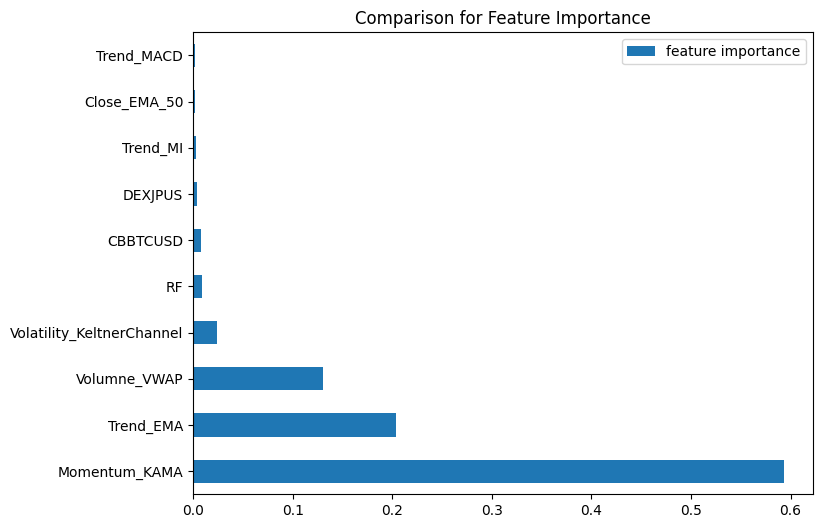

In [26]:
XGB_feature_importance[:10].plot(
    kind="barh", title="Comparison for Feature Importance", figsize=(8, 6)
)

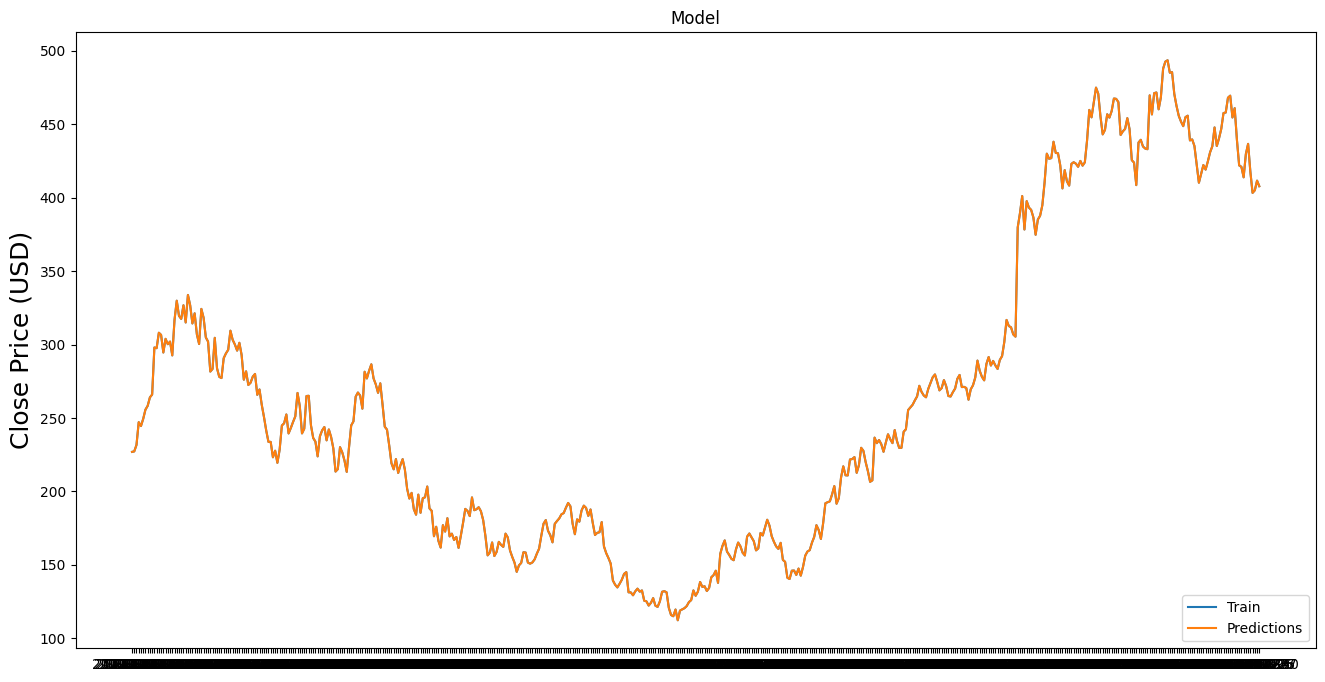

In [27]:
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.ylabel("Close Price (USD)", fontsize=18)
plt.plot(y)
plt.plot(predictions_xgboost)
plt.legend(["Train", "Predictions"], loc="lower right")
plt.show()

In [28]:
predictions_xgboost[1:20]

array([227.26009, 231.65982, 247.17004, 244.50996, 249.41005, 255.67036,
       258.26968, 264.0106 , 265.98038, 298.00934, 297.52014, 308.04025,
       306.56955, 294.59058, 303.90012, 300.2502 , 302.02936, 292.6103 ,
       316.74997], dtype=float32)

## Trading Signals for XGBoost

0 Sell at Open 9622.25 - 25 57
0 Buy Back at Close 9999.5 0


1 Sell at Open 9623.28 - 24 167
1 Buy Back at Close 9605.48 0


2 Sell at Open 9338.16 - 24 204
2 Buy Back at Close 9605.04 0


3 Sell at Open 9319.2 - 24 328
3 Buy Back at Close 9604.96 0


4 Buy at Open 9339.6 24 236
4 Sell at Close 9230.0 0


5 Buy at Open 9053.76 24 372
5 Sell at Close 9614.4 0


6 Buy at Open 9368.88 24 309
6 Sell at Close 9613.8 0


7 Buy at Open 9408.0 24 138
7 Sell at Close 9613.68 0


8 Buy at Open 9242.78 23 178
8 Sell at Close 9613.06 0


9 Sell at Open 9389.52 - 23 153
9 Buy Back at Close 10042.31 0


10 Buy at Open 9798.46 23 232
10 Sell at Close 10042.19 0


11 Buy at Open 9993.5 23 223
11 Sell at Close 10042.16 0


12 Sell at Open 9889.54 - 23 404
12 Buy Back at Close 10479.84 0


13 Sell at Open 10440.24 - 24 149
13 Buy Back at Close 10479.8 0


14 Sell at Open 10140.72 - 24 153
14 Buy Back at Close 10479.0 0


15 Sell at Open 10191.36 - 24 348
15 Buy Back at Close 10478.16 0


16 Buy at Open

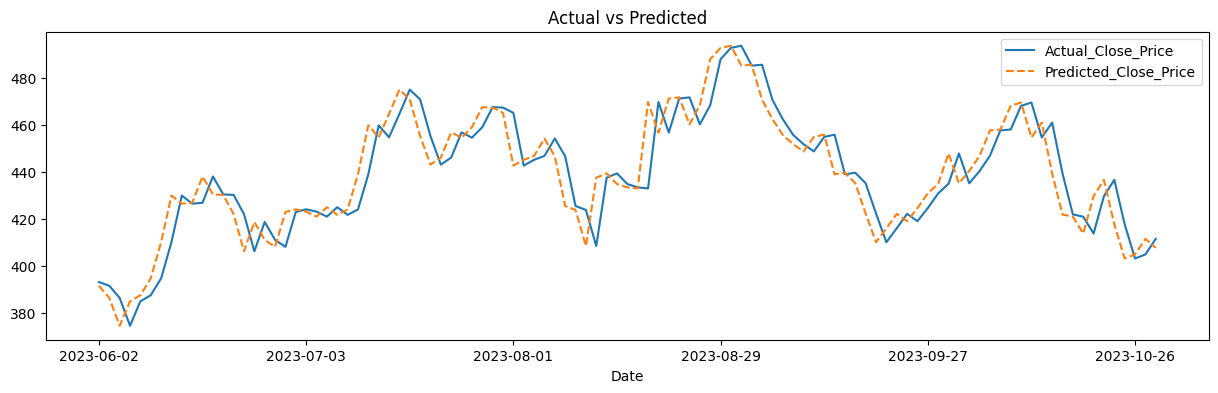

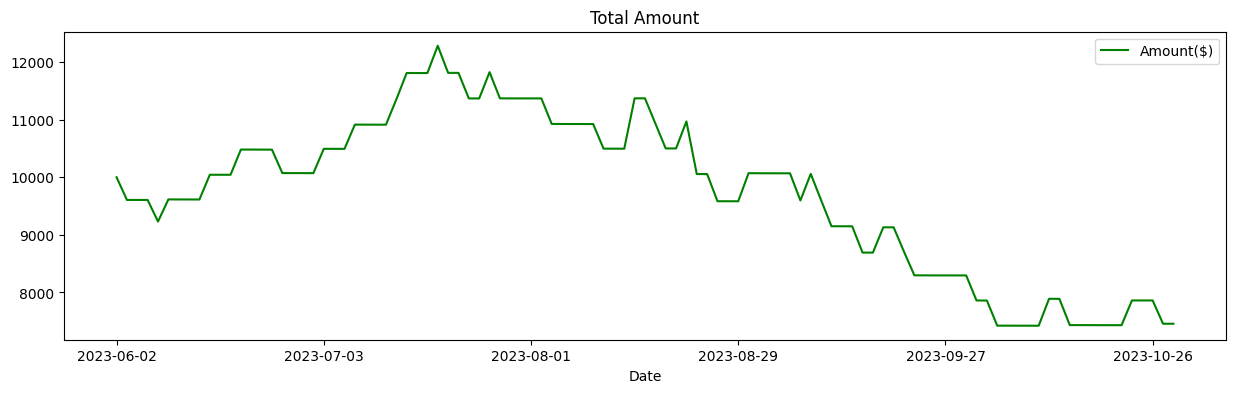

In [29]:
results = pd.DataFrame(
    {
        "Actual": list(y),
        "Predicted": list(predictions_xgboost),
        "Date": nvda.index[:-1],
        "Open": nvda["Open"][:-1],
        "Close": nvda["Close"][:-1],
    }
)
results.set_index("Date", inplace=True)
results = results.loc["2023-06-01":"2023-11-31"]
results.head(10)
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results) - 1):
    if results["Predicted"].iloc[i] > results["Actual"].iloc[i - 1]:
        action.append("Buy at Open & Sell at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Buy at Open", round(portfolio, 2), stocks, round(balance, 2))

        # action.append('Sell at End')
        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Sell at Close", round(amount, 2), balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio, 5))

    else:
        action.append("Sell at Open & Buy at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Sell at Open", round(portfolio, 2), "-", stocks, round(balance, 2))

        # action.append('Buy at Close')
        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Buy Back at Close", round(amount, 2), balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio, 5))
    print("\n")

Strategy_Result = pd.DataFrame(
    {
        "Actual_Close_Price": results.Close[1:],
        "Predicted_Close_Price": results.Predicted[1:],
        "Date": results.index[1:],
        "Amount($)": Amount,
    }
)

Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]].plot(
    figsize=(15, 4), style=["-", "--"], title="Actual vs Predicted"
)


Strategy_Result[["Amount($)"]].plot(figsize=(15, 4), style=["-g"], title="Total Amount")

Profit = (Amount[-1]) / 10000
print("Initial_Investment : 10000$")
print("Net Position:", Amount[-1], "$")

# OLS Regression

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1465.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:20:53   Log-Likelihood:                -1821.1
No. Observations:                 505   AIC:                             3732.
Df Residuals:                     460   BIC:                             3922.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

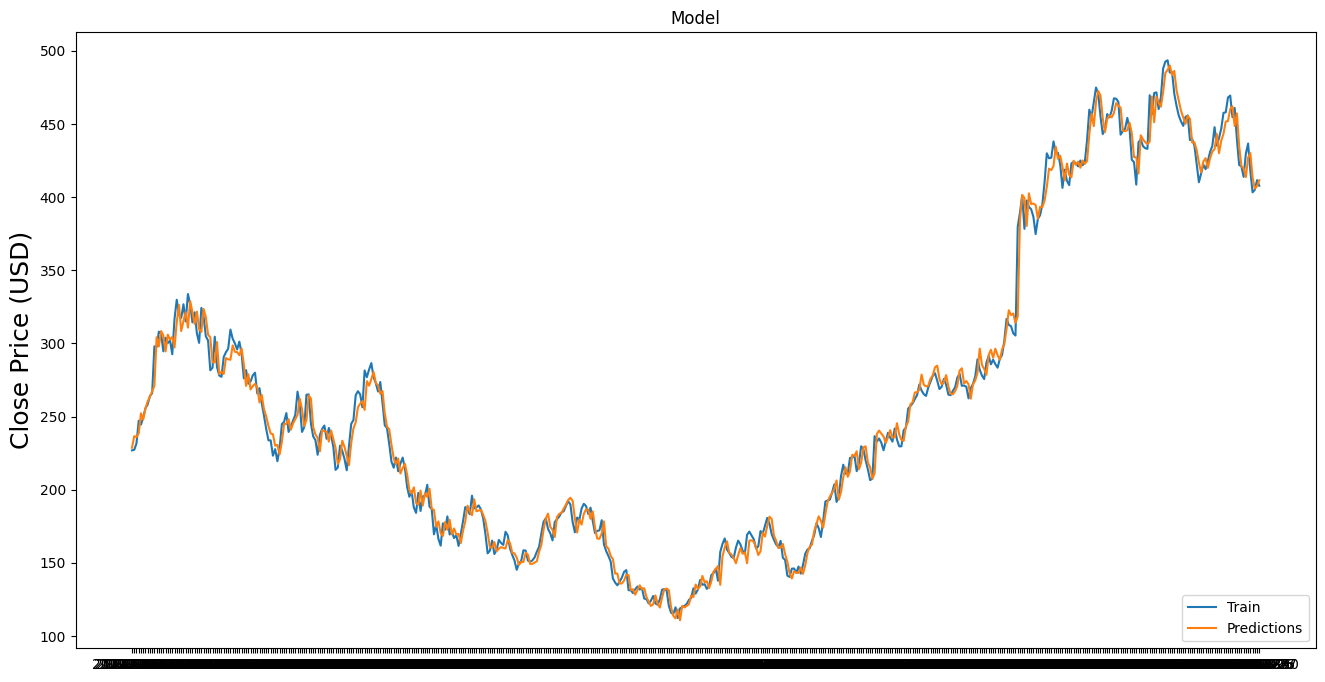

In [30]:
x = sm.add_constant(X)
# Fitting the model
OLS_Model = sm.OLS(y, x).fit()
# Pring OLS results
print(OLS_Model.summary())
predictions_OLS = OLS_Model.predict(x)

# Plot the actual vs. prediction values
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.ylabel("Close Price (USD)", fontsize=18)
plt.plot(y)
plt.plot(predictions_OLS)
plt.legend(["Train", "Predictions"], loc="lower right")
plt.show()

#### RMSE for OLS Regression model

In [31]:
MSE = mean_squared_error(y, predictions_OLS)
RMSE = math.sqrt(MSE)

## Trading Signals for OLS Regression

Root Mean Square Error:

8.910316041180174
0 Sell at Open 9622.25 - 25 57
0 Buy Back at Close 9999.5 0


1 Buy at Open 9623.28 24 167
1 Sell at Close 9605.48 0


2 Buy at Open 9338.16 24 204
2 Sell at Close 9605.04 0


3 Buy at Open 9319.2 24 328
3 Sell at Close 9604.96 0


4 Buy at Open 9339.6 24 236
4 Sell at Close 9230.0 0


5 Buy at Open 9053.76 24 372
5 Sell at Close 9614.4 0


6 Buy at Open 9368.88 24 309
6 Sell at Close 9613.8 0


7 Buy at Open 9408.0 24 138
7 Sell at Close 9613.68 0


8 Sell at Open 9242.78 - 23 178
8 Buy Back at Close 9613.06 0


9 Sell at Open 9389.52 - 23 153
9 Buy Back at Close 10042.31 0


10 Sell at Open 9798.46 - 23 232
10 Buy Back at Close 10042.19 0


11 Sell at Open 9993.5 - 23 223
11 Buy Back at Close 10042.16 0


12 Sell at Open 9889.54 - 23 404
12 Buy Back at Close 10479.84 0


13 Sell at Open 10440.24 - 24 149
13 Buy Back at Close 10479.8 0


14 Sell at Open 10140.72 - 24 153
14 Buy Back at Close 10479.0 0


15 Sell at Open 10191.36 - 24 348
15 Bu

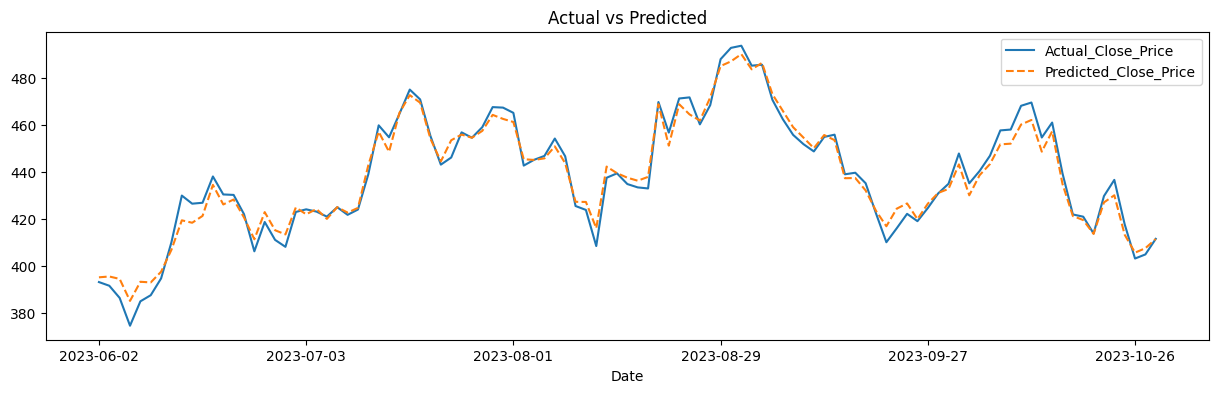

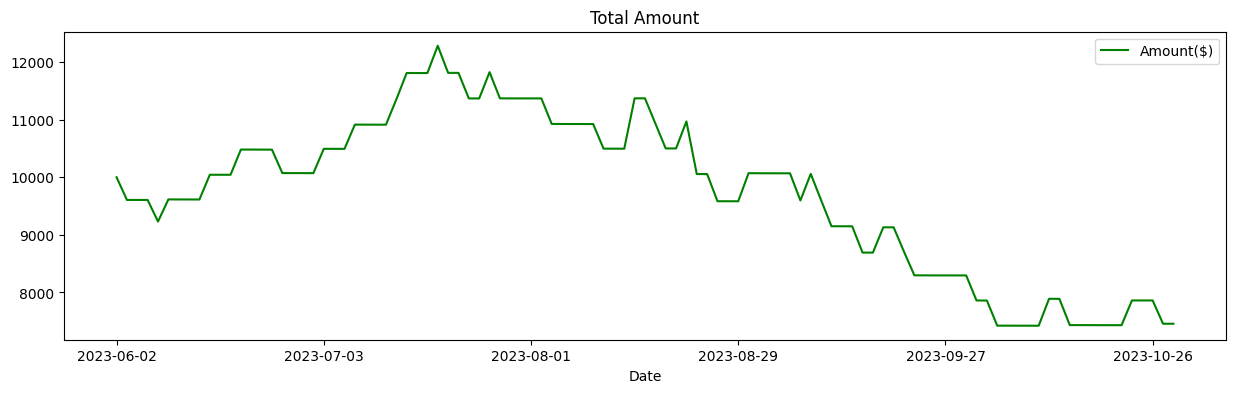

In [32]:
MSE = mean_squared_error(y, predictions_OLS)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
results = pd.DataFrame(
    {
        "Actual": list(y),
        "Predicted": list(predictions_OLS),
        "Date": nvda.index[:-1],
        "Open": nvda["Open"][:-1],
        "Close": nvda["Close"][:-1],
    }
)
results.set_index("Date", inplace=True)
results = results.loc["2023-06-01":"2023-11-31"]
results.head(10)
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results) - 1):
    if results["Predicted"].iloc[i] > results["Actual"].iloc[i - 1]:
        action.append("Buy at Open & Sell at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Buy at Open", round(portfolio, 2), stocks, round(balance, 2))

        # action.append('Sell at End')
        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Sell at Close", round(amount, 2), balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio, 5))

    else:
        action.append("Sell at Open & Bull at Close")
        stocks = int(amount / results["Open"].iloc[i])
        balance = int(amount % results["Close"].iloc[i])
        portfolio = stocks * results["Open"].iloc[i]
        print(i, "Sell at Open", round(portfolio, 2), "-", stocks, round(balance, 2))

        # action.append('Buy at Close')
        portfolio = stocks * results["Close"].iloc[i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i, "Buy Back at Close", round(amount, 2), balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio, 5))
    print("\n")

Strategy_Result = pd.DataFrame(
    {
        "Actual_Close_Price": results.Close[1:],
        "Predicted_Close_Price": results.Predicted[1:],
        "Date": results.index[1:],
        "Amount($)": Amount,
    }
)

Strategy_Result[["Actual_Close_Price", "Predicted_Close_Price"]].plot(
    figsize=(15, 4), style=["-", "--"], title="Actual vs Predicted"
)


Strategy_Result[["Amount($)"]].plot(figsize=(15, 4), style=["-g"], title="Total Amount")

Profit = (Amount[-1]) / 10000
print("Initial_Investment : 10000$")
print("Net Position:", Amount[-1], "$")

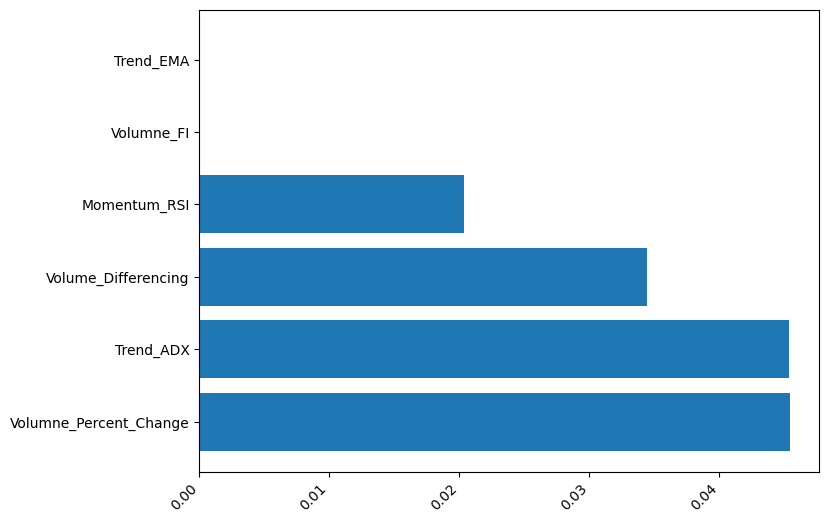

In [33]:
data = pd.DataFrame(OLS_Model.pvalues).reset_index()
data.sort_values(0, inplace=True, ascending=False)

filtered_data = data[data[0] <= 0.05]

plt.figure(figsize=(8, 6))
plt.barh(filtered_data["index"], filtered_data[0])
plt.xticks(rotation=45, ha="right")
plt.show()

## 3. Other regression based models

### 3.1 Benchmark Model

In [34]:
benchmark_prep = sm.OLS(y, X).fit()
benchmark_prep.summary()
benchmark_select = X.columns[np.abs(benchmark_prep.tvalues) >= 1.96]
benchmark = sm.OLS(y, X).fit()
print(benchmark.summary())
y_hat_benchmark1 = benchmark.predict(X)
corr_benchmark1 = ss.pearsonr(y_hat_benchmark1, y)[0]
print("Benchmark: corr (Y, Y_pred) = " + str(corr_benchmark1))
print(
    "Hard Thresholding Selected " + str(len(benchmark_select)) + " features: ",
    benchmark_select.values,
)
MSE = mean_squared_error(y, y_hat_benchmark1)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.044e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:58   Log-Likelihood:                         -1821.3
No. Observations:                 505   AIC:                                      3731.
Df Residuals:                     461   BIC:                                      3916.
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

### 3.2 Factor Selection using Ridge Regression

In [35]:
a = 0.5
model2_prep = linear_model.Ridge(alpha=a, fit_intercept=False).fit(X, y)
model2_select = X.columns[np.abs(model2_prep.coef_) >= 0.001]
x = X[model2_select]
model2 = sm.OLS(y, x).fit()
print(model2.summary())
y_pred_model2 = model2.predict(x)
corr_model2 = ss.pearsonr(y_pred_model2, y)[0]
print("Model 1 - Ridge Regression: corr (Y, Y_pred) = " + str(corr_model2))
print(
    "Ridge Regression selected " + str(len(model2_select)) + " features: ",
    model2_select.values,
)
MSE = mean_squared_error(y, y_pred_model2)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.131e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:59   Log-Likelihood:                         -1834.3
No. Observations:                 505   AIC:                                      3747.
Df Residuals:                     466   BIC:                                      3911.
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.71046e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### 3.3 Factor Selection using LASSO

In [36]:
a = 0.5
model3_prep = linear_model.Lasso(alpha=a, fit_intercept=False).fit(X, y)
model3_select = X.columns[np.abs(model3_prep.coef_) >= 0.001]
x = X
model3 = sm.OLS(y, x).fit()
print(model3.summary())
y_pred_model3 = model3.predict(x)
corr_model3 = ss.pearsonr(y_pred_model3, y)[0]
print("Model 2 - LASSO: corr (Y, Y_pred) = " + str(corr_model3))
print("LASSO selected " + str(len(model3_select)) + " features: ", model3_select.values)
MSE = mean_squared_error(y, y_pred_model3)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.169e+04, tolerance: 4.003e+03
  model = cd_fast.enet_coordinate_descent(


                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.044e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:59   Log-Likelihood:                         -1821.3
No. Observations:                 505   AIC:                                      3731.
Df Residuals:                     461   BIC:                                      3916.
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

### 3.4 Factor Selection using Least Angle Regression

In [37]:
model1_prep = linear_model.Lars().fit(X, y)
model1_select = X.columns[model1_prep.coef_ != 0]
x = X[model1_select]
model1 = sm.OLS(y, x).fit()
print(model1.summary())
y_pred_model1 = model1.predict(x)
corr_model1 = ss.pearsonr(y_pred_model1, y)[0]
print("Model 3 - LARS: corr (Y, Y_pred) = " + str(corr_model1))
print(
    "LARS selected " + str(len(model1_select)) + " features: ",
    model1_select.values + ", ",
)
MSE = mean_squared_error(y, y_pred_model1)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.044e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:59   Log-Likelihood:                         -1821.3
No. Observations:                 505   AIC:                                      3731.
Df Residuals:                     461   BIC:                                      3916.
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

### 3.5 Factor Selection using Elastic Net

In [38]:
a = 1.0
model4_prep = linear_model.ElasticNet(alpha=a, fit_intercept=False).fit(X, y)
model4_select = X.columns[np.abs(model4_prep.coef_) >= 0.001]
x = X[model4_select]
model4 = sm.OLS(y, x).fit()
print(model4.summary())
y_pred_model4 = model4.predict(x)
corr_model4 = ss.pearsonr(y_pred_model4, y)[0]
print("Model 4 - Elastic Net: corr (Y, Y_pred) = " + str(corr_model3))
print(
    "ElasticNet selected " + str(len(model4_select)) + " features: ",
    model4_select.values,
)
MSE = mean_squared_error(y, y_pred_model4)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.636e+04
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:20:59   Log-Likelihood:                         -1840.4
No. Observations:                 505   AIC:                                      3735.
Df Residuals:                     478   BIC:                                      3849.
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e+04, tolerance: 4.003e+03
  model = cd_fast.enet_coordinate_descent(
